This is the final training notebook. Basically here, from a model that was:
1. Fine-tuned for the fruit classification task.
2. Fine-tuned on the acquired dataset.

We will provide with a quantisation-aware procedure to retain some of the performance of the model when quantised.

> The last trained model, when quantised lost 5% of accuracy on the task!

In [3]:
#!pip install -q tensorflow-model-optimization
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import tensorflow_model_optimization as tfmot
from keras.callbacks import EarlyStopping
import tensorflow as tf
from keras import layers
import keras

import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import numpy as np
import itertools
import zipfile
import shutil

RANDOM_SEED = 42

# These are relevant parameters for the trainer
IMAGE_SHAPE = (112, 112)
BATCH_SIZE = 32

2024-01-21 21:30:19.547274: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Load the previously trained model:

In [58]:
MODEL_PATH = 'models/arduino_model'
base_model = keras.models.load_model(MODEL_PATH)
base_model.summary()

Model: "ArduinoModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Backbone (KerasLayer)       (None, 256)               218544    
                                                                 
 BatchNorm1 (BatchNormaliza  (None, 256)               1024      
 tion)                                                           
                                                                 
 Output (Dense)              (None, 6)                 1542      
                                                                 
Total params: 221110 (863.71 KB)
Trainable params: 215126 (840.34 KB)
Non-trainable params: 5984 (23.38 KB)
_________________________________________________________________


Sadly, as the backbone of the model was obtained with `TensorflowHub` we can not realiably quantize the `MobileNet` architecture. Nevertheless, we will quantize the other layers and check if the accuracy improves.

In [108]:
LastValueQuantizer = tfmot.quantization.keras.quantizers.LastValueQuantizer
MovingAverageQuantizer = tfmot.quantization.keras.quantizers.MovingAverageQuantizer


class BNQuantizeConfig(tfmot.quantization.keras.QuantizeConfig):
    def get_weights_and_quantizers(self, layer):
        return [
            (
                layer.weights[i],
                LastValueQuantizer(num_bits=8, symmetric=True, narrow_range=False, per_axis=False),
            )
            for i in range(2)
        ]

    def get_activations_and_quantizers(self, layer):
        return []

    def set_quantize_weights(self, layer, quantize_weights):
        pass

    def set_quantize_activations(self, layer, quantize_activations):
        pass

    def get_output_quantizers(self, layer):
        return [MovingAverageQuantizer(num_bits=8, per_axis=False, symmetric=False, narrow_range=False)]

    def get_config(self):
        return {}


batch_norm_quant = BNQuantizeConfig()
objects = {
    "BNQuantizeConfig": BNQuantizeConfig,
}

def get_quant_head(base_model):
    with tfmot.quantization.keras.quantize_scope(objects):
        classification_head = keras.Sequential(
            [
                tfmot.quantization.keras.quantize_annotate_layer(layers.InputLayer(input_shape=(112, 112, 3))),
                tf.keras.layers.Flatten(),
                tf.keras.layers.Dense(256, activation=None),
                tfmot.quantization.keras.quantize_annotate_layer(
                    base_model.layers[1], quantize_config=batch_norm_quant
                ),
                tfmot.quantization.keras.quantize_annotate_layer(base_model.layers[2]),
            ],
            name="QuantModel",
        )
        classification_head.build([None, 112, 112, 3])
        head_model = tfmot.quantization.keras.quantize_apply(classification_head)
        return head_model


head_model = get_quant_head(base_model)
head_model.summary()

Model: "QuantModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 quantize_layer_24 (Quantiz  (None, 112, 112, 3)       3         
 eLayer)                                                         
                                                                 
 input_1 (InputLayer)        multiple                  0         
                                                                 
 quantize_layer_25 (Quantiz  (None, 112, 112, 3)       3         
 eLayer)                                                         
                                                                 
 flatten_5 (Flatten)         (None, 37632)             0         
                                                                 
 quant_dense_5 (QuantizeWra  (None, 256)               9634051   
 pperV2)                                                         
                                                        

Finally, in order to add also the backbone:

In [113]:
def get_quant_model():

    # These are the two primitives
    base_model = keras.models.load_model(MODEL_PATH)
    head_model = get_quant_head(base_model)

    # The actual
    quant_model = keras.Sequential(
        [   
            head_model.layers[0],
            base_model.layers[0],
            *head_model.layers[5:],
        ],
        name="QAModel",
    )
    quant_model.build([None, 112, 112, 3])
    return quant_model

Check what happened to the model:

In [114]:
model = get_quant_model()
model.summary()

Model: "QAModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 quantize_layer_30 (Quantiz  (None, 112, 112, 3)       3         
 eLayer)                                                         
                                                                 
 Backbone (KerasLayer)       (None, 256)               218544    
                                                                 
 quant_BatchNorm1 (Quantize  (None, 256)               1031      
 WrapperV2)                                                      
                                                                 
 quant_Output (QuantizeWrap  (None, 6)                 1547      
 perV2)                                                          
                                                                 
Total params: 221125 (863.77 KB)
Trainable params: 215126 (840.34 KB)
Non-trainable params: 5999 (23.43 KB)
_________________

## 1. Quant-Aware Training:

Now that we already defined a quant-model. We can training and check if we are able to increase the base accucary:

In [124]:
TRAIN_DATA_FOLDER = "data/TinyDataset/trainData/"
classes = sorted([d for d in os.listdir(TRAIN_DATA_FOLDER) if (os.path.isdir(os.path.join(TRAIN_DATA_FOLDER, d)))])

train_ds = keras.preprocessing.image_dataset_from_directory(
    TRAIN_DATA_FOLDER,
    
    # Define how to load each image
    image_size=IMAGE_SHAPE,
    color_mode="rgb",

    # How to load the labels
    labels="inferred",
    label_mode="categorical",
    class_names=classes,

    # Training related
    batch_size=BATCH_SIZE,
    shuffle=True,
    
    seed=RANDOM_SEED,
)

# Note that the images are loaded with the required shape!!
data_augmentation = tf.keras.Sequential(
    [
        keras.layers.RandomFlip("horizontal_and_vertical"),
        keras.layers.RandomRotation(0.2),
        keras.layers.RandomContrast(factor=(0, 0.2)),
        keras.layers.RandomZoom(height_factor=(-0.05, 0.2)),
        keras.layers.RandomBrightness(factor=(-0.2, 0.2), value_range=[0, 255]),
    ]
)
rescale_processing = tf.keras.Sequential([
    layers.Rescaling(1.0 / 255)
])

# Apply the preprocessing
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))
train_ds = train_ds.map(lambda x, y: (rescale_processing(x, training=True), y))

Found 242 files belonging to 6 classes.


Again check the images:

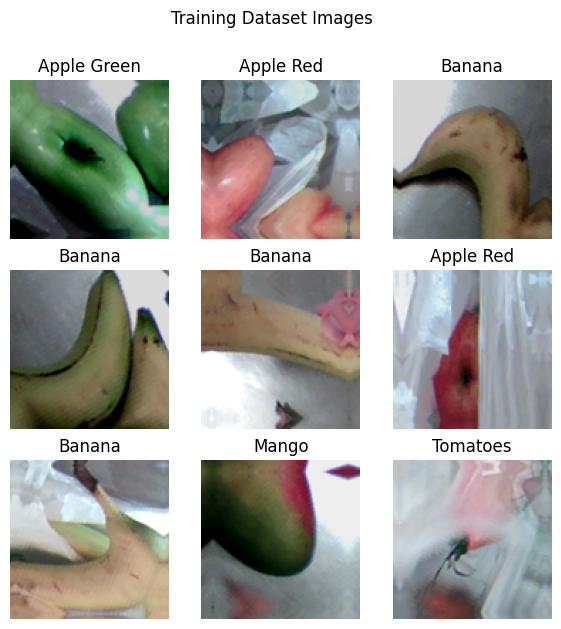

In [116]:
plt.figure(figsize=(7, 7))

for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(classes[tf.argmax(labels[i])])
        plt.axis("off")

# Visualize training dataset
plt.suptitle("Training Dataset Images")
plt.show()

Get the model and train it. Here it is important to note a few design things:

1) Normally, because of the lower representation, `QuantLayers` will be much more prone to overfitting than normal layers. Hence we need heavy regularisation.

2) We want to train for a small number of epochs

In [131]:
# Define a scheduler for the training (very mildly reducing)
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    1e-4, # From a small LR so we do not change to much the params
    decay_rate=0.5,
    decay_steps=1000,
)

optim = keras.optimizers.Adam(
    learning_rate=lr_schedule,
    weight_decay=1.5e-1, # Heavy weight decay!!
)

# Get the model and compile it
quant_model = get_quant_model()
quant_model.compile(
    loss=keras.losses.CategoricalCrossentropy(from_logits=True),
    optimizer=optim,
    metrics=[keras.metrics.CategoricalAccuracy()],
)

# Train the models
quant_model.fit(
    train_ds,
    epochs=16,
)

Epoch 1/16
8/8 [==============================] - 10s 150ms/step - loss: 0.5908 - categorical_accuracy: 0.8140
Epoch 2/16
8/8 [==============================] - 1s 152ms/step - loss: 0.6834 - categorical_accuracy: 0.7893
Epoch 3/16
8/8 [==============================] - 1s 151ms/step - loss: 0.6447 - categorical_accuracy: 0.7934
Epoch 4/16
8/8 [==============================] - 1s 144ms/step - loss: 0.5543 - categorical_accuracy: 0.8223
Epoch 5/16
8/8 [==============================] - 1s 149ms/step - loss: 0.4518 - categorical_accuracy: 0.8471
Epoch 6/16
8/8 [==============================] - 1s 153ms/step - loss: 0.4933 - categorical_accuracy: 0.8471
Epoch 7/16
8/8 [==============================] - 1s 150ms/step - loss: 0.4523 - categorical_accuracy: 0.8554
Epoch 8/16
8/8 [==============================] - 1s 150ms/step - loss: 0.4461 - categorical_accuracy: 0.8760
Epoch 9/16
8/8 [==============================] - 1s 148ms/step - loss: 0.3812 - categorical_accuracy: 0.8967
Epoch 10/

Finally, we can remove the extra layers:

In [139]:
final_model = keras.models.Sequential(
    [
        quant_model.layers[1],
        quant_model.layers[2],
        quant_model.layers[3],
    ],
    name="QATModel",
)

final_model.build([None, 112, 112, 3])
final_model.compile(
    loss=keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=[keras.metrics.CategoricalAccuracy()],
)

Now we store the resulting model:

In [140]:
final_model.save("models/QA_model")

INFO:tensorflow:Assets written to: models/QA_model/assets


INFO:tensorflow:Assets written to: models/QA_model/assets


In [132]:
TEST_DATA_FOLDER = "data/TinyDataset/testData/"
classes = sorted([d for d in os.listdir(TEST_DATA_FOLDER) if (os.path.isdir(os.path.join(TEST_DATA_FOLDER, d)))])

test_ds = keras.preprocessing.image_dataset_from_directory(
    TEST_DATA_FOLDER,
    # Define how to load each image
    image_size=IMAGE_SHAPE,
    color_mode="rgb",
    # How to load the labels
    labels="inferred",
    label_mode="categorical",
    class_names=classes,
    # Training related
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=RANDOM_SEED,
)

rescale_processing = tf.keras.Sequential([layers.Rescaling(1.0 / 255)])

# Apply the preprocessing
test_ds = test_ds.map(lambda x, y: (rescale_processing(x, training=False), y))

Found 61 files belonging to 6 classes.


In [133]:
quant_model.evaluate(test_ds)

2/2 [==============================] - 1s 34ms/step - loss: 0.4892 - categorical_accuracy: 0.8361


[0.48915231227874756, 0.8360655903816223]